# semantic segmentation with PyTorch

## import libraries

In [1]:
# . . import libraries
import os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision

# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# , , pandas
import pandas as pd
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style

# . . for model summary
from torchsummary import summary

# . . for idential transformation the image and mask
import albumentations as transforms

# . . import libraries by tugrulkonuk
import utils
from dataset import TGSSaltDataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 100
    # . . the learning rate 
    lr = 0.001

    # . . batch_size
    batch_size = 64

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.0005

    # . . patience for early stopping
    patience = 20

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## import the data


In [5]:
# . . data root path
dataroot = 'competition_data'
# . . path for training data
trainpath = dataroot+'/train'
# . . validation data
testpath = dataroot+'/test'

# . . transformer for data augmentation
#transformer_train = transforms.Compose([
#                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#                    transforms.RandomCrop(32, padding=4),
#                    transforms.RandomHorizontalFlip(p=0.5),
#                    transforms.RandomRotation(degrees=15),
#                    transforms.RandomAffine(0, translate=(0.1, 0.1)),
#                    transforms.RandomPerspective(),
#                    transforms.ToTensor(),                                            
#                  ])

transform = transforms.Compose([
            transforms.HorizontalFlip(p=0.5),
            transforms.VerticalFlip(p=0.5),
            transforms.Rotate(limit=45, p=0.5),                                      
          ])


# . . get the list of files
allfiles = utils.get_file_list(trainpath+'/images')
allidx = np.linspace(0, len(allfiles)-1, len(allfiles), dtype=np.int)

train_idx, valid_idx = train_test_split(allidx, test_size=0.2, shuffle=True)
train_idx = np.unique(train_idx)
valid_idx = np.unique(valid_idx)


train_files = np.array(allfiles)[train_idx]
valid_files = np.array(allfiles)[valid_idx]


#train_files = utils.get_file_list(trainpath+'/images')
test_files = utils.get_file_list(testpath+'/images')

# . . read depths 
depths = pd.read_csv(dataroot+'/depths.csv')

# . . the training set
train_dataset = TGSSaltDataset(trainpath, train_files, transform=None, mask=True, imgsize=(128,128), grayscale=True)

# . . the validation set
valid_dataset = TGSSaltDataset(trainpath, valid_files, transform=None, mask=True, imgsize=(128,128), grayscale=True)

# . . the test set
test_dataset = TGSSaltDataset(testpath, test_files, transform=None, mask=False, imgsize=(128,128), grayscale=True)


## data loaders

In [6]:
# . . the training loader: shuffle
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

In [7]:
# . . test the loader by retrieveing the batch info 
utils.batchinfo(trainloader, label=True)
utils.batchinfo(validloader, label=True)

------------------
There are 50 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([64, 1, 128, 128])
Label:   torch.Size([64, 1, 128, 128])
------------------
------------------
There are 13 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([64, 1, 128, 128])
Label:   torch.Size([64, 1, 128, 128])
------------------


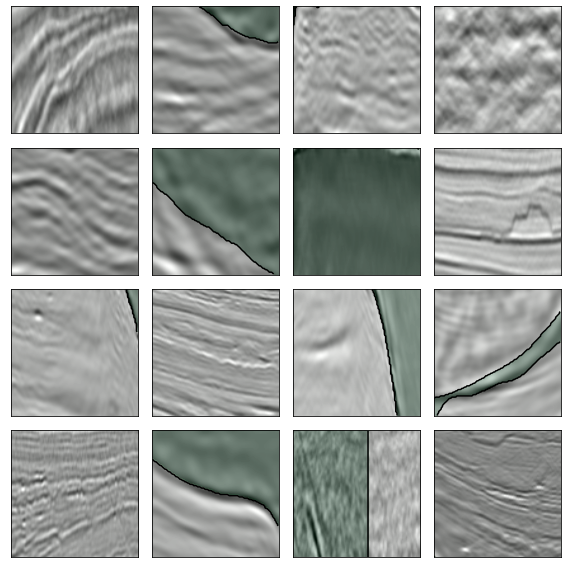

In [8]:
# . . plot some images
images, masks = next(iter(trainloader))
utils.plot_masks(images, masks, 4, 4, figsize=(2,2))

In [9]:
# . . instantiate the model
model = AttentionUNet()

# . . send model to device (GPU)
model.to(device)

AttentionUNet(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [10]:
# . . show a summary of the model
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
        conv_block-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,640
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 32, 64, 64]           9,248
      BatchNorm2d-13           [-1, 32, 64, 64]              64
             ReLU-14           [-1, 32,

(tensor(2184453), tensor(2184453))

In [11]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = nn.BCEWithLogitsLoss()

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(monitor='train_loss'), EarlyStopping(monitor='train_loss', min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':5,
                   'threshold':1e-5,
                   'cooldown':5,
                   'min_lr':1e-4,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

In [12]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, scheduler=scheduler, num_epochs=num_epochs)

Training started:  January 20, 2021 - 11:45PM
Epoch:     0	Train Loss: 0.542353	Valid Loss: 0.655175	Elapsed time: 0:00:09.797628
Epoch:     1	Train Loss: 0.430947	Valid Loss: 0.462002	Elapsed time: 0:00:09.208783
Epoch:     2	Train Loss: 0.381288	Valid Loss: 0.383339	Elapsed time: 0:00:09.546623
Epoch:     3	Train Loss: 0.332559	Valid Loss: 0.366806	Elapsed time: 0:00:09.688303
Epoch:     4	Train Loss: 0.300239	Valid Loss: 0.295333	Elapsed time: 0:00:09.608127
Epoch:     5	Train Loss: 0.273695	Valid Loss: 0.367951	Elapsed time: 0:00:09.666586
Epoch:     6	Train Loss: 0.256273	Valid Loss: 0.417444	Elapsed time: 0:00:09.707236
Epoch:     7	Train Loss: 0.241205	Valid Loss: 0.264143	Elapsed time: 0:00:09.544562
Epoch:     8	Train Loss: 0.226222	Valid Loss: 0.365873	Elapsed time: 0:00:09.443972
Epoch:     9	Train Loss: 0.221665	Valid Loss: 0.214487	Elapsed time: 0:00:09.601888
Epoch:    10	Train Loss: 0.204672	Valid Loss: 0.282834	Elapsed time: 0:00:09.470995
Epoch:    11	Train Loss: 0.201

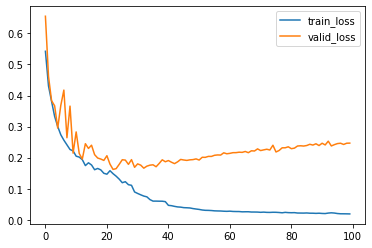

In [13]:
# . . plot the test and validation losses
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

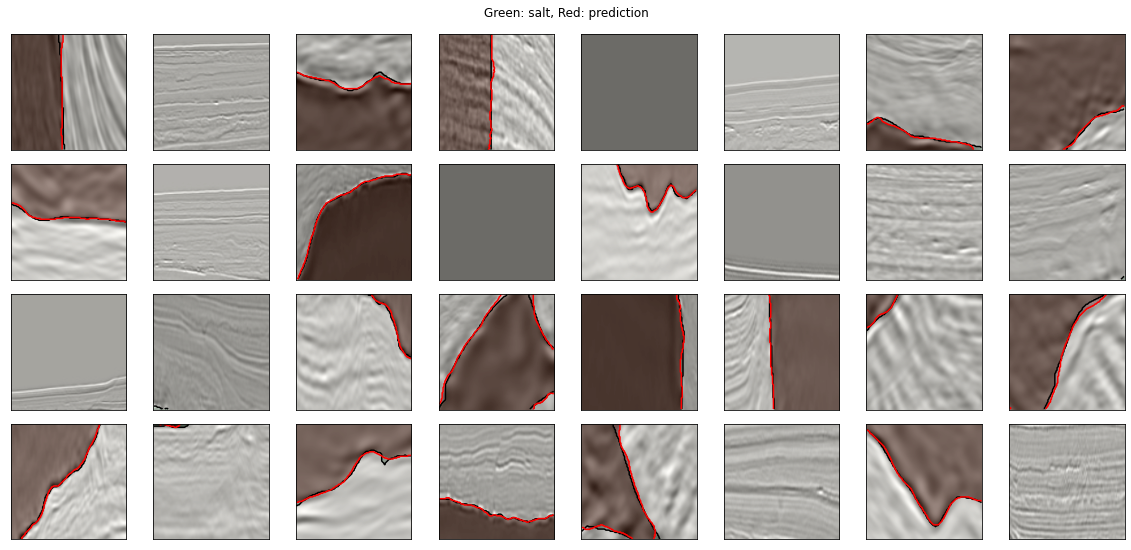

In [40]:
# . . test the trained network
# . . retrieve a new batch
#images, masks_true = next(iter(validloader))
images, masks_true = next(iter(trainloader))

# . . send images to device
images = images.to(device)
with torch.no_grad():
    # . . pass through the network
    outputs = trainer.model(images)

# . . send to CPU 
outputs    = outputs.cpu()

IoU = utils.get_iou_score(outputs, masks).numpy()

# . . convert images and masks to numpy
images     = images.cpu().numpy()
masks_true = masks_true.numpy()

masks_unet = torch.where((outputs)<0., torch.zeros_like(outputs), torch.ones_like(outputs)).numpy()

utils.compare_masks(images, masks_true, masks_unet, 4, 8, iou=None, figsize=(2,2))
#utils.plot_masks(images, masks_unet, 4, 4, figsize=(2,2))

